In [14]:
# Compute multivalency of motif trimers in the 3'regions of regulated gene-groups
# Get the last 100 nts before the terminal polyA site
# Count the number of 3mers motifs in this terminal region in UP / DOWN / CONTROL -  compare the counts between these three groups

In [15]:
from glob import glob
import pandas as pd
import seaborn as sns
import pybedtools as pbt
import os
import sys
import matplotlib as mpl
from statannotations.Annotator import Annotator

In [16]:
def readBed(f):
    return pd.read_csv(f, sep='\t', header=None)

def getFeaturesStarts(df):
    """
    Gets starts of input features, returns bed6.
    """
    df.loc[df[5]=='+', 'adj_end'] = df.loc[df[5]=='+', 1]
    df.loc[df[5]=='+', 'adj_start'] = df.loc[df[5]=='+', 'adj_end'] - 1
    df.loc[df[5]=='-', 'adj_start'] = df.loc[df[5]=='-', 2]
    df.loc[df[5]=='-', 'adj_end'] = df.loc[df[5]=='-', 'adj_start'] + 1
    df[['adj_start', 'adj_end']] = df[['adj_start', 'adj_end']].astype(int)
    bt = pbt.BedTool().from_dataframe(df[[0, 'adj_start', 'adj_end', 3, 4, 5]]).sort()
    return bt

In [17]:
# import terminal PAS
pas_groups = glob('../../data/TerminalPas/terminal_pa_signals_*')
# import motif groups
motifs = [
    '../../results/FindMotifs/full_utrs/motifs_TTT.bed.gz',
    '../../results/FindMotifs/full_utrs/motifs_ATT.bed.gz',
    '../../results/FindMotifs/full_utrs/motifs_GAT.bed.gz',
    '../../results/FindMotifs/full_utrs/motifs_GGA,GGT.bed.gz',
    '../../results/FindMotifs/full_utrs/motifs_AAA.bed.gz',
]

# fasta index
fai = '../../data/genomes/Goodwright_m39/GRCm39.primary_assembly.genome.fa.fai'

# How many nts before pA are we interested in?
w=100

# Save to
outpath = '../../results/CharacterizationOfQuantseqGroups/Multivalency'
os.makedirs(outpath, exist_ok=True)
srcOut = '../../results/SourceData/raw_saved/'
os.makedirs(srcOut, exist_ok=True)

In [18]:
pas_groups

['../../data/TerminalPas/terminal_pa_signals_UP.bed.gz',
 '../../data/TerminalPas/terminal_pa_signals_CONTROL.bed.gz',
 '../../data/TerminalPas/terminal_pa_signals_DOWN.bed.gz']

In [19]:
dfCombined = pd.DataFrame()
for pas in pas_groups:
    # group
    g = pas.split('_')[-1].split('.')[0]
    # Get regions of interest
    bt = getFeaturesStarts(readBed(pas).drop_duplicates())
    bt = bt.slop(l=w, r=0, s=True, g=fai).sort()
    # map motifs to regions
    columns = []
    for m in motifs:
        bt_m = pbt.BedTool(m).sort()
        columns.append(m.split('/')[-1].split('_')[1].split('.')[0])
        bt = bt.map(bt_m, s=True, F=.8, c=6, o='count')
    dfCounts = bt.to_dataframe(disable_auto_names=True, header=None)
    dfCounts.rename(columns=dict(zip(dfCounts.columns.tolist()[6:], columns)), inplace=True)
    dfCounts['group'] = g
    dfCombined = pd.concat([dfCombined, dfCounts])
dfCombined = dfCombined.melt(value_vars=columns, id_vars=[c for c in dfCombined.columns.tolist() if c not in columns], var_name='motif', value_name='count')

In [20]:
# Combine U-rich trimers (sum)
dfCombineUrich = dfCombined.loc[dfCombined.motif.isin(['TTT', 'ATT'])].groupby([0, 1, 2, 3, 4, 5, 'group'], as_index=True).sum()['count'].reset_index()
dfCombineUrich['motif'] = 'UUU,AUU'
# Remove individual trimers from original dataframe
dfCombined = dfCombined.loc[~dfCombined.motif.isin(['TTT', 'ATT'])]
dfCombineUrich.head()

,0,1,2,3,4,5,group,count,motif
0,chr1,4843455,4843556,ENSMUSG00000033845,0,-,CONTROL,5,"UUU,AUU"
1,chr1,4968005,4968106,ENSMUSG00000033813,0,+,DOWN,11,"UUU,AUU"
2,chr1,9617555,9617656,ENSMUSG00000061024,0,+,DOWN,14,"UUU,AUU"
3,chr1,10095074,10095175,ENSMUSG00000025917,0,-,CONTROL,4,"UUU,AUU"
4,chr1,10206870,10206971,ENSMUSG00000056763,0,+,CONTROL,15,"UUU,AUU"


In [21]:
dfCombined = pd.concat([dfCombined, dfCombineUrich[dfCombined.columns.tolist()]])

In [22]:
dfCombined.groupby(['motif', 'group']).count()[0]

motif    group  
AAA      CONTROL    2126
         DOWN       1002
         UP          778
GAT      CONTROL    2126
         DOWN       1002
         UP          778
GGA,GGT  CONTROL    2126
         DOWN       1002
         UP          778
UUU,AUU  CONTROL    2126
         DOWN       1002
         UP          778
Name: 0, dtype: int64

GGA,GGT
DOWN vs. CONTROL: Mann-Whitney-Wilcoxon test two-sided, P_val:1.897e-11 U_stat=9.096e+05
CONTROL vs. UP: Mann-Whitney-Wilcoxon test two-sided, P_val:2.270e-02 U_stat=7.821e+05
GAT
DOWN vs. CONTROL: Mann-Whitney-Wilcoxon test two-sided, P_val:6.194e-01 U_stat=1.076e+06
CONTROL vs. UP: Mann-Whitney-Wilcoxon test two-sided, P_val:2.462e-01 U_stat=8.492e+05
UUU,AUU
DOWN vs. CONTROL: Mann-Whitney-Wilcoxon test two-sided, P_val:4.306e-25 U_stat=1.308e+06
CONTROL vs. UP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.264e-17 U_stat=9.975e+05
AAA
DOWN vs. CONTROL: Mann-Whitney-Wilcoxon test two-sided, P_val:3.074e-19 U_stat=1.274e+06
CONTROL vs. UP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.005e-09 U_stat=9.474e+05


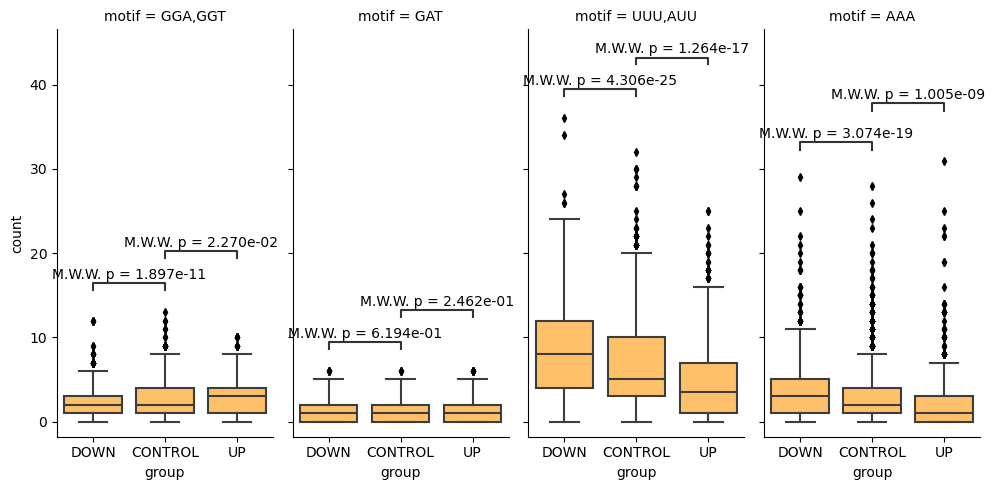

In [23]:
g = sns.catplot(
    data=dfCombined, kind='box', col='motif',
    x='group', y='count', order=['DOWN', 'CONTROL', 'UP'], showfliers=True,
    sharey=True, aspect=.5, saturation=1, **{'boxprops': {'facecolor': mpl.colors.to_rgba('#ffa62b', alpha=.7)},
    'flierprops':{'marker':'d', 'markerfacecolor':'black', 'markersize':4,  'markeredgecolor': 'black'}},
    col_order=['GGA,GGT', 'GAT', 'UUU,AUU', 'AAA']
    )


pairs = [('DOWN', 'CONTROL'), ('CONTROL', 'UP')]

for id, ax in g.axes_dict.items():
    print(id)
    # subset the table otherwise the stats were calculated on the whole dataset
    annot = Annotator(
        ax, pairs,data=dfCombined.loc[dfCombined['motif']==id,:], x='group',  y='count', order=['DOWN', 'CONTROL', 'UP'],
        )
    annot.configure(test='Mann-Whitney', text_format='full', loc='inside')
    _, corrected_results = annot.apply_and_annotate()


g.fig.savefig(f'{outpath}/trimer_counts_{w}_upstream_of_PAS.pdf', bbox_inches='tight')

In [24]:
dfCombined.loc[dfCombined.motif=='UUU,AUU'].groupby('group').median()['count']

group
CONTROL    5.0
DOWN       8.0
UP         3.5
Name: count, dtype: float64

In [27]:
# Save source data
dfSrc = dfCombined.copy()
# Name columns
dfSrc.columns = ['chrom', 'start', 'end', 'geneId', 'score', 'strand', 'gene group', '3mer', f'3mer count in region ({w}nt upstream of PAS)']
# Drop score column and save
dfSrc.drop('score', axis=1).to_csv(f'{srcOut}/3merCounts_{w}ntUpstreamOfPas.csv', index=False)